# Exploring the data (Plitt & Giocomo 2021)

### `pynwb`
For more info on the `pynwb` package and the `NWB` format, see the [docs](https://pynwb.readthedocs.io/en/stable/). They include lots of tutorials and useful information for making the most of this format.

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pynwb

## Set some basic parameters

In [3]:
filepath = Path("data\TestPlitt", "sub-R2_ses-20190219T210000_behavior+ophys_small.nwb")

## Open the file for reading
For simplicity, we will just open the file to read it (without the context manager `with`).

In [4]:
read_io = pynwb.NWBHDF5IO(filepath, "r")
read_nwbfile = read_io.read()

### Quick look at the structure

In [5]:
read_nwbfile

root pynwb.file.NWBFile at 0x1323295561712
Fields:
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: TwoTower_foraging
  experimenter: ['Mark Plitt']
  file_create_date: [datetime.datetime(2021, 3, 2, 9, 7, 9, 325078, tzinfo=tzoffset(None, -18000))]
  identifier: 1b52974c-450b-4200-a83b-664cc5a15bed
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Stanford University School of Medicine
  lab: GiocomoLab
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: TwoTower_foraging_002_003
  session_start_time: 2019-02-19 21:00:00-08:00
  stimulus: {
    bckgndJitter <class 'pynwb.base.TimeSeries'>,
    morph <class 'pynwb.base.TimeSeries'>,
    reward <class 'pynwb.base.TimeSeries'>,
    towerJitter <class 'pynwb.base.TimeSeries'>,
    wallJitter <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at 0x13

## Main data types

### General info

In [6]:
print("Subject info:")
for key, value in read_nwbfile.subject.fields.items():
    print(f"    {key:13}: {value}")

print("\nSession info:")    
print(f"    date/time  : {read_nwbfile.session_start_time}")
print(f"    description: {read_nwbfile.session_description}")

Subject info:
    genotype     : CaMKII-cre hemizygous
    sex          : MALE
    species      : Mus musculus
    subject_id   : R2
    weight       : 23.0 g
    date_of_birth: 2018-11-06 21:00:00-08:00

Session info:
    date/time  : 2019-02-19 21:00:00-08:00
    description: TwoTower_foraging_002_003


### Imaging plane
We can see what the imaging plane looked like, and even which neurons were identified.

In [7]:
def plot_plane(data):
    # plot
    fig, ax = plt.subplots()
    ax.imshow(data.T, cmap="Greys_r")

    # aesthetics
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

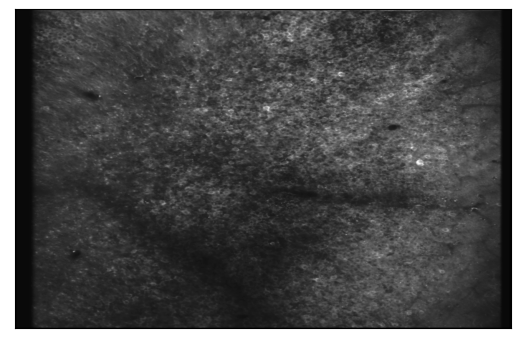

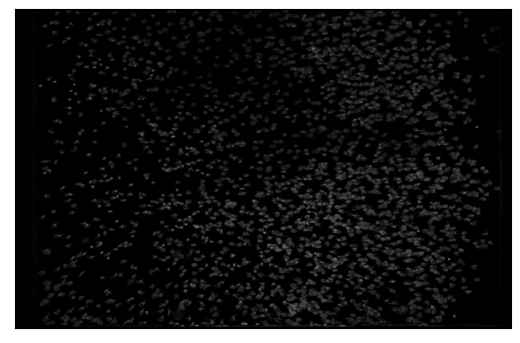

In [8]:
# plot the imaging plane
imaging_plane = read_nwbfile.processing["ophys"]["SegmentationImages"].images["mean"][()]
plot_plane(imaging_plane)

# plot the ROI masks (takes a bit of time to load!)
masks_flat = read_nwbfile.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]["image_mask"].data[()].max(axis=0)
plot_plane(masks_flat);

### ROI response series

In [9]:
ROI_traces = read_nwbfile.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data
print("{} frames x {} neurons".format(*ROI_traces.shape))

31932 frames x 2050 neurons


In [10]:
def normalize_and_plot(ROI_traces, num_plot=5):
    
    # select first N ROIs
    selected_ROI_traces = ROI_traces[:, : num_plot]
    
    # normalize each trace to between 0 and 1 for visualization
    maxes = selected_ROI_traces.max(keepdims=True)
    mins = selected_ROI_traces.min(keepdims=True)
    norm_responses = (selected_ROI_traces - mins) / (maxes - mins)
    
    # separate the traces in the y axis, so they don't overlap when plotted
    norm_responses_shifted = norm_responses + np.arange(num_plot).reshape(1, -1) * 1.1
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(norm_responses_shifted, alpha=0.8, color="k", lw=1)
    ax.set_title("Normalized ROI reponses")
    ax.set_xlabel("Frames")
    
    # aesthetics
    ax.yaxis.set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

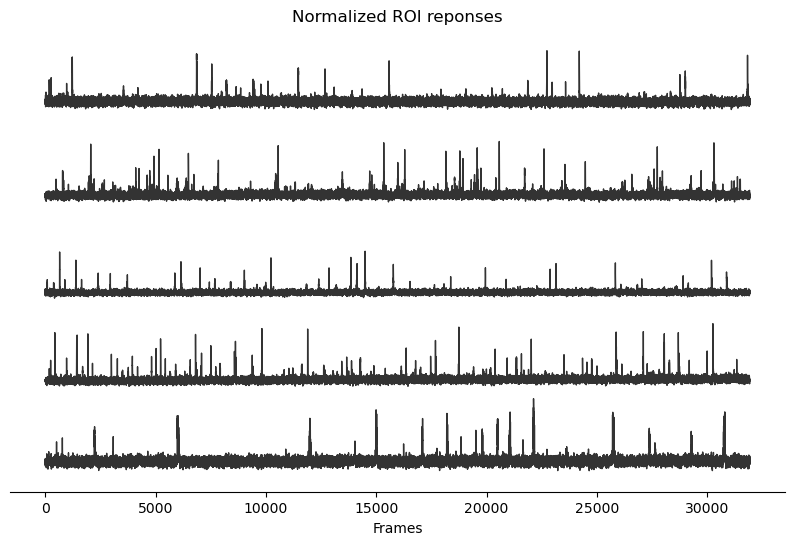

In [11]:
# for a quick visualization, we can plot a few ROIs, each normalized and separated so they don't overlap
normalize_and_plot(ROI_traces);

### Behaviour

In [12]:
print("Behavioural data info:")
for key, value in read_nwbfile.processing["behavior"]["BehavioralTimeSeries"].time_series.items():
    print(f"    {key:9}: {value.description} ({len(value.data)} frames)")

Behavioural data info:
    dz       : (virtual cm) raw rotary encoder information (31932 frames)
    lick     : number of licks in 2P frame (31932 frames)
    lick rate: smooth version of no. licks (31932 frames)
    pos      : (virtual cm) position on virtual reality track (31932 frames)
    rzone    : information about collisions with objects in virtual track, 0-collision (31932 frames)
    speed    : mouse's speed on ball (31932 frames)
    teleport : information about collisions with objects in virtual track, 0-collision (31932 frames)
    tstart   : information about collisions with objects in virtual track, 0-collision (31932 frames)


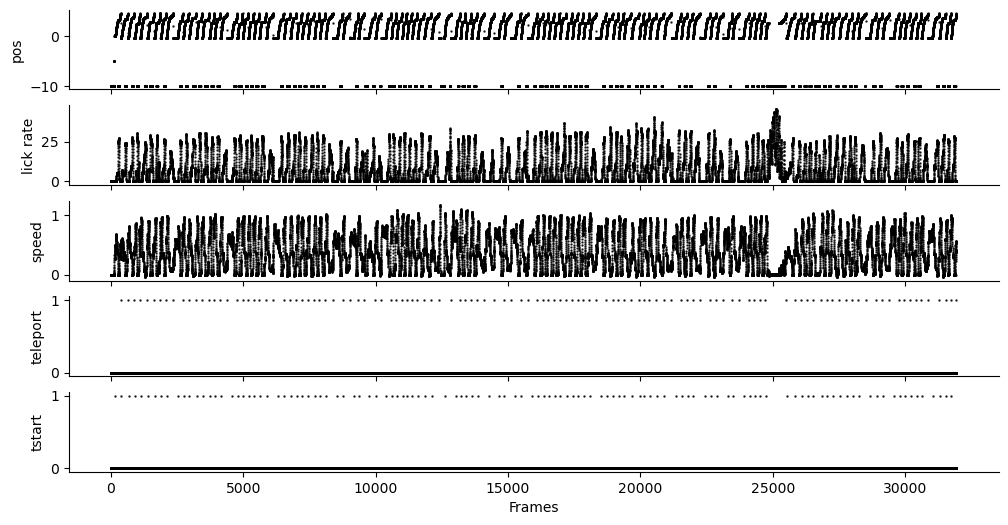

In [13]:
# plot some behavioral data
keys = ["pos", "lick rate", "speed", "teleport", "tstart"]
fig, ax = plt.subplots(len(keys), 1, figsize=[12, 6], sharex=True)

for k, key in enumerate(keys):
    data = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"][key].data[()]

    # plot
    ax[k].plot(data, lw=0, marker=".", ms=1.5, color="k", alpha=0.8)
    ax[k].set_ylabel(key)

    # aesthetics
    for spine in ["top", "right"]:
        ax[k].spines[spine].set_visible(False)

ax[-1].set_xlabel("Frames");

### Stimulus

In [14]:
print("Stimulus data info:")
for key, value in read_nwbfile.stimulus.items():
    print(f"    {key:12}: {value.description} ({len(value.data)} frames)")

Stimulus data info:
    bckgndJitter: information about stimulus in arbitrary units (31932 frames)
    morph       : information about stimulus in arbitrary units (31932 frames)
    reward      : number of rewards dispensed  (31932 frames)
    towerJitter : information about stimulus in arbitrary units (31932 frames)
    wallJitter  : information about stimulus in arbitrary units (31932 frames)


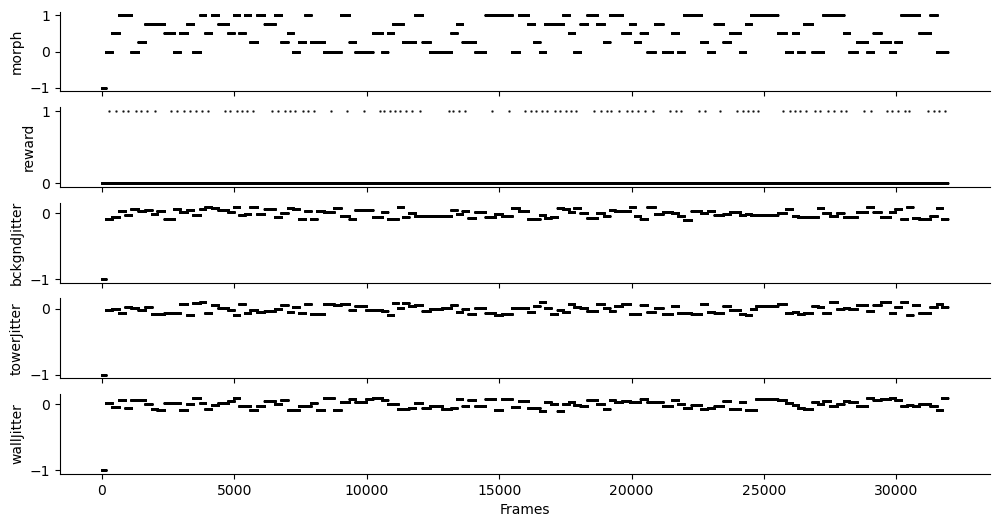

In [15]:
# plot some stimulus data
keys = ["morph", "reward", "bckgndJitter", "towerJitter", "wallJitter"]
fig, ax = plt.subplots(len(keys), 1, figsize=[12, 6], sharex=True)

for k, key in enumerate(keys):
    data = read_nwbfile.stimulus[key].data[()]

    # plot
    ax[k].plot(data, lw=0, marker=".", ms=1.5, color="k", alpha=0.8)
    ax[k].set_ylabel(key)

    # aesthetics
    for spine in ["top", "right"]:
        ax[k].spines[spine].set_visible(False)

ax[-1].set_xlabel("Frames");

In [16]:
tstartData = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["tstart"].data[()]
trials = sum(tstartData)
# trials
for i in range(len(tstartData)):
    if tstartData[i] == 1:
        myIndex = i
        break
print(i)

teleport = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["teleport"].data[()]
trials = sum(teleport)
print(trials)
for i in range(len(teleport)):
    if teleport[i] == 1:
        myIndexp = i
        break
print(myIndexp)

157
120.0
369


In [52]:
myIndices = np.where(tstartData)[0]
print(myIndices)

[  157   398   665   911  1129  1402  1662  1899  2114  2526  2741  2962
  3243  3463  3736  3923  4157  4561  4791  4994  5207  5413  5620  5885
  6304  6546  6792  7033  7228  7454  7697  7901  8126  8552  8773  9179
  9366  9742 10005 10380 10603 10803 11013 11191 11384 11599 11847 12127
 12600 13014 13212 13414 13634 13863 14263 14645 14863 15274 15497 15912
 16115 16339 16546 16754 16967 17226 17437 17654 17855 18090 18494 18717
 18975 19190 19385 19675 19965 20146 20358 20620 20903 21338 21550 21780
 21996 22428 22648 22894 23294 23489 23892 24121 24326 24528 24735 25547
 25854 26099 26318 26522 26851 27055 27259 27523 27798 28027 28244 28671
 28923 29158 29573 29789 29981 30215 30435 30635 31031 31309 31548 31743]


Text(0, 0.5, 'Total Morph')

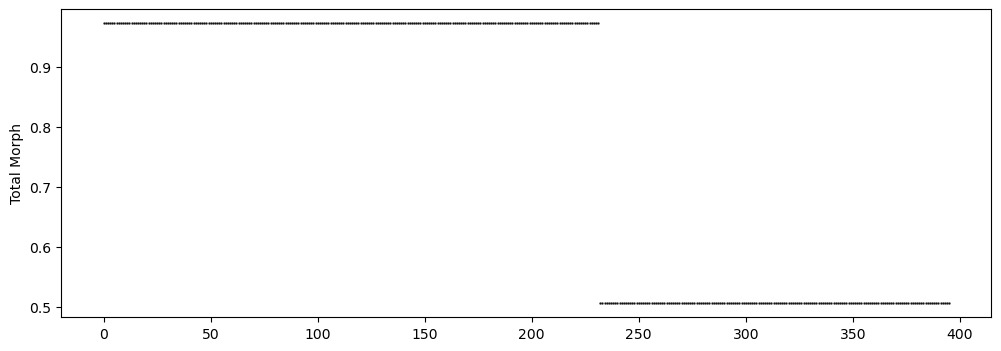

In [91]:
morph = read_nwbfile.stimulus["morph"].data[()]
wallJitter = read_nwbfile.stimulus["wallJitter"].data[()]

totalMorph = morph + wallJitter

fig, ax = plt.subplots(figsize=[12, 4])

il = 48;
ax.plot(totalMorph[myIndices[-5]:myIndices[-4]], lw=0, marker=".", ms=1.5, color="k", alpha=0.8)
ax.set_ylabel("Total Morph")

120


Text(0, 0.5, 'Total Morph')

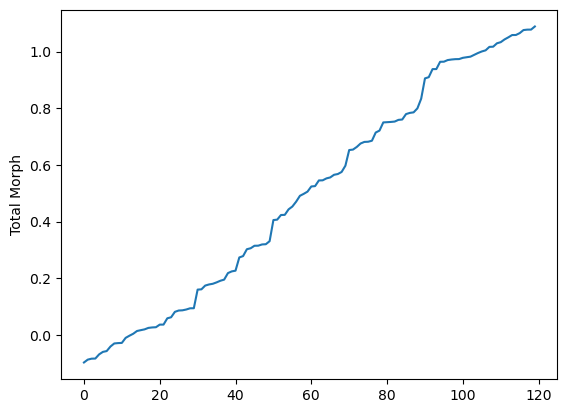

In [19]:
# How many unique values do we have for the total morph?
uniqueVals, uniqueIndices, uniqueInv, uniqueCounts = np.unique(totalMorph, True, True, True)
uniqueVals = uniqueVals[1:]
uniqueIndices = uniqueIndices[1:]
uniqueCounts = uniqueCounts[1:]
print(np.size(uniqueIndices))
plt.plot(uniqueVals)
plt.ylabel("Total Morph")

The morph values more or less give a good enough spread over the space from -0.1 and 1.1 (of morph values)

In [20]:
df = np.zeros([120, 1000])
deconvTraces = read_nwbfile.processing["ophys"]["Fluorescence"]["Deconvolved"].data

# for cell 1, index 0 in python
deconvTrCell1 = deconvTraces[:,0]

for i in range(len(uniqueVals)):
    l = uniqueIndices[i]
    r = l + uniqueCounts[i]
    dist = r - l
    df[i,0:dist] = deconvTrCell1[l:r]
    
# The issue here is that each trial/run takes a different amount of frames. We need to use the position of the mouse and
# bin the data (activity) corresponding to its respective position

the values are l =  16525 and r =  16732


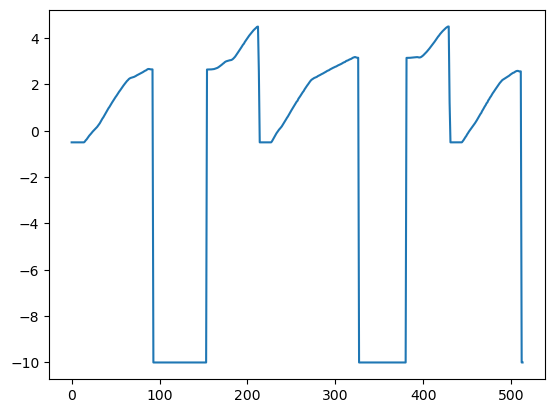

In [21]:
position = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"]["pos"].data[()]
l = uniqueIndices[0]
r = l + uniqueCounts[0]
plt.plot(position[17201 : 17715])
print("the values are l = ",l, "and r = ", r)

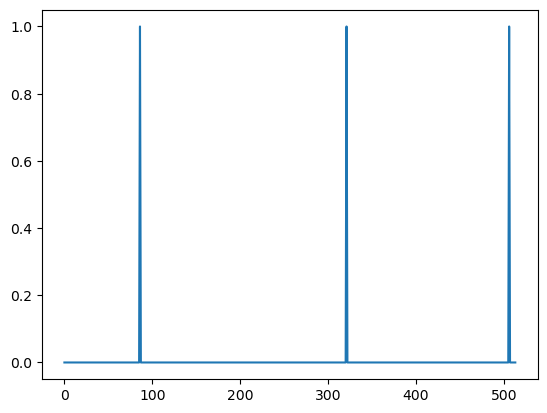

In [23]:
reward = read_nwbfile.stimulus["reward"].data[()]
plt.plot(reward[17201 : 17715])

In [24]:
def positionalBin(data, pos):
    bins = np.arange(0, 4.51, 0.1)
    avgResp = np.zeros(len(bins))

    for i in range(len(bins)-1):
        counter = 0 # to keep track of how many data points, to average after accumulation
        for j in range(len(pos)):
            if (bins[i] <= pos[j] < bins[i+1]): # if the position falls within the interval
                avgResp[i] = avgResp[i] + data[j] # keep accumulating the fluoresence data points in this interval
                counter = counter + 1 # keeps track of how many data points are added to average in the end
        if counter != 0: # to avoid dividing by zero if there aren't any datapoints in a bin
            avgResp[i] = avgResp[i]/counter # gets average of the sum after all values in phi have been looped over
    return avgResp
   
    

In [92]:
df = np.zeros([120, 46])
deconvTraces = read_nwbfile.processing["ophys"]["Fluorescence"]["Deconvolved"].data

# for cell 1, index 0 in python
deconvTrCell1 = deconvTraces[:,1]

for i in range(119):
    l = int(myIndices[i])
    r = int(myIndices[i+1])
    cellActivity = positionalBin(deconvTrCell1[l:r], position[l:r])
    df[i,:] = cellActivity/np.mean(cellActivity)
    # df[i,:] = cellActivity   
    
    

0.21195652173913043

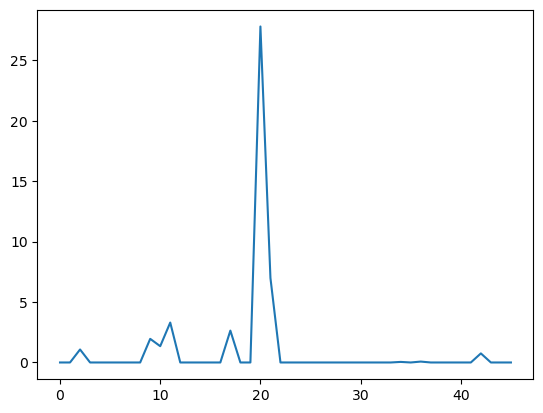

In [103]:
plt.plot(df[37,:])
len(np.where(df.reshape(-1))[0])/df.size

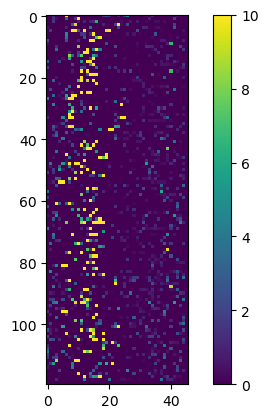

In [265]:
plt.figure()
plt.imshow(df/np.mean(df), vmin=0, vmax=10)
plt.colorbar()

In [161]:
from scipy.ndimage import filters

In [266]:
def figsmooth(A,sig):
    '''apply Gaussian smoothing to matrix A containing nans with kernel sig
    without propogating nans'''

    # find zero indices to weight the smoothing matrix
    zero_inds = np.where(A == 0)

    # inversely weight zero indices
    One = np.ones(A.shape)
    One[zero_inds] = .001
    A = filters.gaussian_filter(A,sig)
    One = filters.gaussian_filter(One,sig)
    return A/One

C:\Users\tarek\AppData\Local\Temp\ipykernel_31116\1136186852.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_31116\1136186852.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


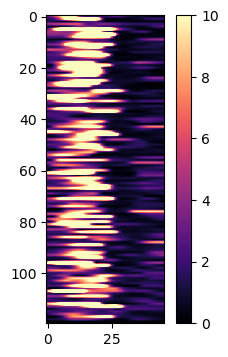

In [268]:
plt.figure(figsize=[3,4])
plt.imshow(figsmooth(df,[0,3])/np.mean(df), cmap='magma', vmin=0, vmax=)
plt.colorbar()

https://github.com/GiocomoLab/PlittGiocomo_2021/blob/master/morph_analyses/PlaceCellAnalysis.py

C:\Users\tarek\AppData\Local\Temp\ipykernel_31116\1136186852.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_31116\1136186852.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


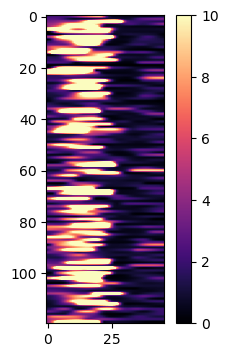

In [269]:
smoothedNorm = figsmooth(df,[0,3])/np.mean(df)
morphOrder = np.argsort(uniqueIndices)
plt.figure(figsize=[3,4])
plt.imshow(smoothedNorm[morphOrder,:], cmap='magma', vmin=0, vmax=10)
plt.colorbar()

### How many cells are tuned for reward region?

In [115]:
# How many cells in total?
print("{} frames x {} neurons".format(*ROI_traces.shape))
nTotal = ROI_traces.shape[1]

# Find whether a place cell is ever tuned for reward region
def tunedInReward(deconvData, position, indices):
    rTuned = 0; # Variable to keep track of tuning
    # Bin the activity in the positional bins
    for i in range(119):
        l = int(indices[i])
        r = int(indices[i+1])
        cellActivity = positionalBin(deconvData[l:r], position[l:r])
        if 25 <= cellActivity.argmax() <= 40: # if max is within the reward region
            rTuned = 1
            break
        
    return rTuned
    
    
        
    

31932 frames x 2050 neurons


In [117]:
deconvTraces = read_nwbfile.processing["ophys"]["Fluorescence"]["Deconvolved"].data

tunedForRwd = np.zeros([2050,1])
for i in range(2050):
    tunedForRwd[i] = tunedInReward(deconvTraces[:,i], position, myIndices)
    
print(np.where(tunedForRwd)[0])

KeyboardInterrupt: 

# Below this point is testing/debugging code

In [107]:
a = 1;
b = 4;
c = 7;
print(a < b < c)

True


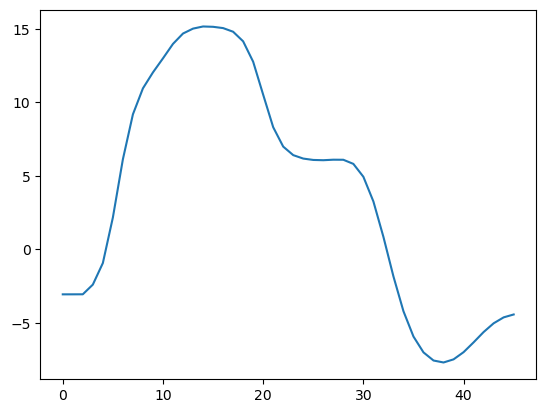

In [257]:
v1 = smoothedNorm
v2 = smoothedNorm[morphOrder,:]
plt.plot(v2[62,:]-v1[0,:])

In [184]:
testing = np.asarray([[0, 0, 12, -2.1, 0],[5, 0, 0, 1, 1]])
inds = np.where(testing == 0)
print(inds)
testing1 = np.ones(testing.shape)
testing1[inds]=0.001
print(testing1)

(array([0, 0, 0, 1, 1], dtype=int64), array([0, 1, 4, 1, 2], dtype=int64))
[[0.001 0.001 1.    1.    0.001]
 [1.    0.001 0.001 1.    1.   ]]


In [119]:
print(myIndices[0])
print(np.sort(uniqueIndices))
print(myIndices - np.sort(uniqueIndices))

157.0
[  134   371   638   881  1104  1374  1634  1872  2090  2357  2717  2938
  3216  3440  3712  3901  4134  4395  4768  4972  5184  5390  5598  5860
  6135  6524  6770  7009  7206  7433  7674  7879  8104  8384  8750  9013
  9344  9569  9980 10217 10581 10782 10992 11169 11362 11577 11823 12101
 12378 12848 13191 13393 13612 13837 14099 14481 14840 15108 15473 15747
 16094 16318 16525 16732 16944 17201 17415 17631 17832 18068 18330 18695
 18952 19168 19362 19648 19940 20123 20336 20597 20875 21172 21528 21757
 21973 22261 22625 22867 23129 23467 23717 24096 24302 24505 24708 25512
 25825 26077 26291 26501 26828 27033 27238 27498 27769 28005 28222 28506
 28901 29134 29407 29764 29960 30187 30412 30611 30867 31284 31524 31721]
[ 23.  27.  27.  30.  25.  28.  28.  27.  24. 169.  24.  24.  27.  23.
  24.  22.  23. 166.  23.  22.  23.  23.  22.  25. 169.  22.  22.  24.
  22.  21.  23.  22.  22. 168.  23. 166.  22. 173.  25. 163.  22.  21.
  21.  22.  22.  22.  24.  26. 222. 166.  21.  21.

In [263]:
# print(uniqueVals)
print(np.argsort(uniqueIndices))
print(uniqueIndices[np.argsort(uniqueIndices)])
# print(uniqueCounts)

[ 16  55 113  93  23  45  80  75  71  60  14  50  79  27 107  52 102  84
  62 119  56  96  31 100  88 105  47  51   1  39  97  41  30  28   2 110
  48  20  24  69  22  58  82  74  33  36 108  35  10   4  54  89  40  44
   9 116  90 117   7 111  76  37   0  85  83  70 104  61  11  78 115  81
  34 114 109  64  86  42  68  21  87   8  67  13  92 103  32   6  77  43
  53  18  72  91 118  66  15  57   5  73  19  12 112  94 106  63  17  38
  29  65  49  25  46  95 101  98  59  99   3  26]
[  134   371   638   881  1104  1374  1634  1872  2090  2357  2717  2938
  3216  3440  3712  3901  4134  4395  4768  4972  5184  5390  5598  5860
  6135  6524  6770  7009  7206  7433  7674  7879  8104  8384  8750  9013
  9344  9569  9980 10217 10581 10782 10992 11169 11362 11577 11823 12101
 12378 12848 13191 13393 13612 13837 14099 14481 14840 15108 15473 15747
 16094 16318 16525 16732 16944 17201 17415 17631 17832 18068 18330 18695
 18952 19168 19362 19648 19940 20123 20336 20597 20875 21172 21528 21757
 

In [262]:
np.shape(np.argsort(uniqueIndices))



(120,)

## End
I suppose to be absolutely correct, we should technically close our file when we are done... But that is very annoying in a jupyter notebook where cells are often run out of order! So I'll leave it commented out.

In [15]:
# read_io.close()